# Time Series Prediction

**Objectives**
 1. Build a linear, DNN and CNN model in keras to predict stock market behavior
 2. Build a simple RNN model and a multi-layer RNN model in keras
 3. Combine RNN and CNN architecture to create a keras model to predict stock market behavior
 4. Use the tf.data pipeline to train a time series model on larger dataset
 
In this lab we will build a custom Keras model to predict stock market behavior using the stock market dataset we created in the previous labs. We'll start with a linear, DNN and CNN model 

Since the features of our model are sequential in nature, we'll next look at how to build various RNN models in keras. We'll start with a simple RNN model and then see how to create a multi-layer RNN in keras. We'll also see how to combine features of 1-dimensional CNNs with a typical RNN architecture. 

We will be exploring a lot of different model types in this notebook. To keep track of your results, record the accuracy on the validation set in the table here. In machine learning there are rarely any "one-size-fits-all" so feel free to test out different hyperparameters (e.g. train steps, regularization, learning rates, optimizers, batch size) for each of the models. Keep track of your model performance in the chart below.

|  Model   | Validation Accuracy  |
|----------|:---------------:|
| Baseline |    0.496         |
| Linear   |    --        |
| DNN      |    --         |
| 1-d CNN  |    --         |
| simple RNN  |    --         |
| multi-layer RNN  |    --         |
| RNN using CNN features  |    --         |
| CNN using RNN features  |    --         |

## Load necessary libraries and set up environment variables

In [23]:
import datetime
import os
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, DenseFeatures,
                                     Conv1D, MaxPool1D,
                                     Reshape, RNN,
                                     LSTM, GRU, Bidirectional)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [24]:
PROJECT = "munn-sandbox"  # Replace with your PROJECT
BUCKET = "munn-sandbox"  # Replace with your BUCKET
REGION = "us-east1"            # Choose an available region for Cloud MLE
#PROJECT = "your-gcp-project-here" # REPLACE WITH YOUR PROJECT NAME
#BUCKET = "your-gcp-bucket-here" # REPLACE WITH YOUR BUCKET
#REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

In [25]:
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

## Explore time series data

We'll start by pulling a small sample of the time series data from Big Query and write some helper functions to clean up the data for modeling. We'll use the data from the `percent_change_sp500` table in BigQuery. The `close_values_prior_260` column contains the close values for any given stock for the previous 260 days. 

In [15]:
%%time
bq = bigquery.Client(project=PROJECT)

bq_query = '''
#standardSQL
SELECT
  symbol,
  Date,
  direction,
  close_values_prior_260
FROM
  `stock_market.percent_change_sp500`
LIMIT
  100
'''

df_stock_raw = bq.query(bq_query).to_dataframe()

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 2.16 s


In [16]:
df_stock_raw.head()

,symbol,Date,direction,close_values_prior_260
0,BSX,2006-05-19,STAY,"[29.5, 29.75, 30.42, 30.36, 30.3, 30.75, 30.8,..."
1,AEP,1996-02-09,STAY,"[35.0, 34.88, 35.0, 35.75, 34.88, 35.13, 34.63..."
2,AEP,2003-10-07,STAY,"[27.06, 28.91, 28.61, 28.51, 29.98, 28.74, 27...."
3,ABT,2001-12-20,UP,"[54.06, 53.75, 51.19, 51.06, 49.69, 50.06, 50...."
4,BAC,1987-10-05,UP,"[46.5, 46.0, 45.75, 45.13, 45.25, 45.5, 44.38,..."


The function `clean_data` below does three things:
 1. First, we'll remove any inf or NA values
 2. Next, we parse the `Date` field to read it as a string.
 3. Lstly, we convert the label `direction` into a numberic quantity, mapping 'DOWN' to 0, 'STAY' to 1 and 'UP' to 2. 

In [65]:
def clean_data(input_df):
    """Cleans data to prepare for training.

    Args:
        input_df: Pandas dataframe.
    Returns:
        Pandas dataframe.
    """
    df = input_df.copy()

    # Remove inf/na values.
    real_valued_rows = ~(df == np.inf).max(axis=1)
    df = df[real_valued_rows].dropna()

    # TF doesn't accept datetimes in DataFrame.
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # TF requires numeric label.
    df['direction_numeric'] = df['direction'].apply(lambda x: {'DOWN': 0,
                                                               'STAY': 1,
                                                               'UP': 2}[x])
    return df

In [66]:
df_stock = clean_data(df_stock_raw)

In [67]:
df_stock.head()

,symbol,Date,direction,close_values_prior_260,direction_numeric
0,BSX,2006-05-19,STAY,"[29.5, 29.75, 30.42, 30.36, 30.3, 30.75, 30.8,...",1
1,AEP,1996-02-09,STAY,"[35.0, 34.88, 35.0, 35.75, 34.88, 35.13, 34.63...",1
2,AEP,2003-10-07,STAY,"[27.06, 28.91, 28.61, 28.51, 29.98, 28.74, 27....",1
3,ABT,2001-12-20,UP,"[54.06, 53.75, 51.19, 51.06, 49.69, 50.06, 50....",2
4,BAC,1987-10-05,UP,"[46.5, 46.0, 45.75, 45.13, 45.25, 45.5, 44.38,...",2


## Read data and preprocessing

Before we begin modeling, we'll preprocess our features by scaling to the z-score. This will ensure that the range of the feature values being fed to the model are comparable and should help with convergence during gradient descent.

In [4]:
STOCK_HISTORY_COLUMN = 'close_values_prior_260'
COL_NAMES = ['day_' + str(day) for day in range(0, 260)]
LABEL = 'direction_numeric'

In [69]:
def _scale_features(df):
    """z-scale feature columns of Pandas dataframe.

    Args:
        features: Pandas dataframe.
    Returns:
        Pandas dataframe with each column standardized according to the
        values in that column.
    """
    avg = df.mean()
    std = df.std()
    return (df - avg)/std


def create_features(df, label_name):
    """Create modeling features and label from Pandas dataframe.

    Args:
        df: Pandas dataframe.
        label_name: str, the column name of the label.
    Returns:
        Pandas dataframe
    """
    # Expand 1 column containing a list of close prices to 260 columns.
    time_series_features = df[STOCK_HISTORY_COLUMN].apply(pd.Series)

    # Rename columns.
    time_series_features.columns = COL_NAMES
    time_series_features = _scale_features(time_series_features)

    # Concat time series features with static features and label.
    label_column = df[LABEL]

    return pd.concat([time_series_features,
                      label_column], axis=1)

In [22]:
df_features = create_features(df_stock, LABEL)

In [23]:
df_features.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_251,day_252,day_253,day_254,day_255,day_256,day_257,day_258,day_259,direction_numeric
0,-0.509075,-0.497042,-0.464794,-0.467682,-0.470570,-0.448910,-0.446504,-0.456130,-0.467682,-0.469607,...,-0.873433,-0.900868,-0.917714,-0.905200,-0.932635,-0.938892,-0.922046,-0.937448,-0.952369,1
1,-0.244350,-0.250126,-0.244350,-0.208251,-0.250126,-0.238093,-0.262159,-0.286225,-0.316548,-0.328581,...,0.188836,0.188836,0.200869,0.195093,0.176803,0.188836,0.176803,0.188836,0.152737,1
2,-0.626517,-0.537473,-0.551912,-0.556726,-0.485972,-0.545655,-0.582717,-0.712673,-0.749253,-0.826264,...,-0.549987,-0.534585,-0.510038,-0.485009,-0.485009,-0.504262,-0.485009,-0.491266,-0.479233,1
3,0.673042,0.658121,0.534903,0.528646,0.462706,0.480515,0.486772,0.564745,0.387620,0.324086,...,0.725024,0.742351,0.676892,0.623947,0.631167,0.689407,0.670154,0.662934,0.709622,2
4,0.309165,0.285099,0.273067,0.243225,0.249001,0.261034,0.207126,0.267291,0.279324,0.285099,...,-0.761767,-0.743958,-0.749734,-0.761767,-0.743958,-0.743958,-0.755991,-0.749734,-0.755991,2


Let's plot a few examples and see that the preprocessing steps were implemented correctly.

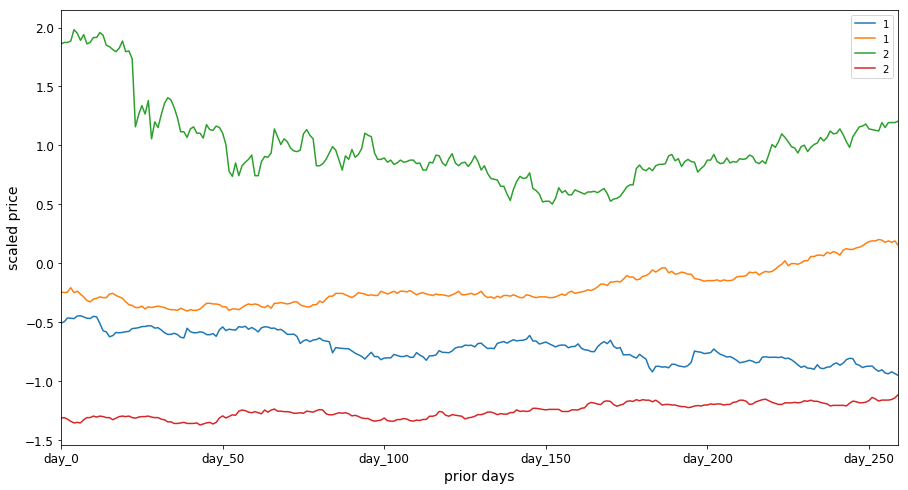

In [70]:
ix_to_plot = [0, 1, 9, 5]
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for ix in ix_to_plot:
    label = df_features['direction_numeric'].iloc[ix]
    example = df_features[COL_NAMES].iloc[ix]
    ax = example.plot(label=label, ax=ax)
    ax.set_ylabel('scaled price')
    ax.set_xlabel('prior days')
    ax.legend()

### Make train-eval-test split

Next, we'll make repeatable splits for our train/validation/test datasets and save these datasets to local csv files. The query below will take a subsample of the entire dataset and then create a 70-15-15 split for the train/validation/test sets. 

In [71]:
def _create_split(phase):
    """Create string to produce train/valid/test splits for a SQL query.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
    Returns:
        String.
    """
    floor, ceiling = 0, 80
    if phase == 'VALID':
        floor, ceiling = 80, 90
    elif phase == 'TEST':
        floor, ceiling = 90, 100
    return '''
    AND MOD(ABS(FARM_FINGERPRINT(symbol)), EVERY_N * 100) >= (EVERY_N * {0})
    AND MOD(ABS(FARM_FINGERPRINT(symbol)), EVERY_N * 100) < (EVERY_N * {1})
    '''.format(floor, ceiling)


def create_query(phase, sample_size):
    """Create SQL query to create train/valid/test splits on subsample.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
        sample_size: str, amount of data to take for subsample.
    Returns:
        String.
    """
    basequery = """
    #standardSQL
    SELECT
      symbol,
      Date,
      direction,
      close_values_prior_260
    FROM
      `stock_market.percent_change_sp500`
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(Date AS STRING))), EVERY_N) = 0
    """
    query = basequery + _create_split(phase)
    return query.replace("EVERY_N", sample_size)

In [27]:
bq = bigquery.Client(project=PROJECT)

for phase in ['TRAIN', 'VALID', 'TEST']:
    # 1. Create query string
    query_string = create_query(phase, '500')
    # 2. Load results into DataFrame
    df = bq.query(query_string).to_dataframe()

    # 3. Clean, preprocess dataframe
    df = clean_data(df)
    df = create_features(df, label_name='direction_numeric')

    # 3. Write DataFrame to CSV
    if not os.path.exists('./data'):
        os.mkdir('./data')
    df.to_csv('./data/stock-{}.csv'.format(phase.lower()),
              index_label=False, index=False)
    print("Wrote {} lines to {}".format(
        len(df),
        './data/stock-{}.csv'.format(phase.lower())))

Wrote 5337 lines to ./data/stock-train.csv
Wrote 593 lines to ./data/stock-valid.csv
Wrote 563 lines to ./data/stock-test.csv


In [5]:
ls -la ./data

total 14088220
drwxr-xr-x 3 jupyter jupyter        4096 Nov  2 17:32 ./
drwxr-xr-x 5 jupyter jupyter        4096 Nov  3 02:24 ../
drwxr-xr-x 2 jupyter jupyter        4096 Oct 30 19:25 .ipynb_checkpoints/
-rw-r--r-- 1 jupyter jupyter  1284528964 Nov  2 17:34 large-stock-test.csv
-rw-r--r-- 1 jupyter jupyter 11692756837 Nov  2 17:07 large-stock-train.csv
-rw-r--r-- 1 jupyter jupyter  1376107043 Nov  2 17:21 large-stock-valid.csv
-rw-r--r-- 1 jupyter jupyter     3399547 Nov  1 21:19 small-stock-test.csv
-rw-r--r-- 1 jupyter jupyter    32197146 Nov  1 21:19 small-stock-train.csv
-rw-r--r-- 1 jupyter jupyter     3593523 Nov  1 21:19 small-stock-valid.csv
-rw-r--r-- 1 jupyter jupyter     2917139 Nov  2 15:05 stock-test.csv
-rw-r--r-- 1 jupyter jupyter    27749376 Nov  2 15:05 stock-train.csv
-rw-r--r-- 1 jupyter jupyter     3047685 Nov  2 15:05 stock-valid.csv


## Modeling

For experimentation purposes, we'll train various models using data we can fit in memory using the `.csv` files we created above. 

In [8]:
N_TIME_STEPS = 260
N_LABELS = 3

Xtrain = pd.read_csv('data/stock-train.csv')
Xvalid = pd.read_csv('data/stock-valid.csv')

ytrain = Xtrain.pop(LABEL)
yvalid  = Xvalid.pop(LABEL)

ytrain_categorical = to_categorical(ytrain.values)
yvalid_categorical = to_categorical(yvalid.values)

To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [9]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

### Baseline

Before we begin modeling in keras, let's create a benchmark using a simple heuristic. Let's see what kind of accuracy we would get on the validation set if we predict the majority class of the training set. 

In [10]:
sum(yvalid == ytrain.value_counts().idxmax())/yvalid.shape[0]

0.4957841483979764

Ok. So just naively guessing the most common outcome `STAY` will give about 49.6% accuracy on the validation set. 

### Linear model

We'll start with a simple linear model, mapping our sequential input to a single fully dense layer. 

In [32]:
#TODO 1a
model = Sequential()
model.add(Dense(units=N_LABELS,
                activation='softmax'))

model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=100,
                    verbose=0)

W1102 15:07:00.305717 140104478889728 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1102 15:07:00.372866 140104478889728 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


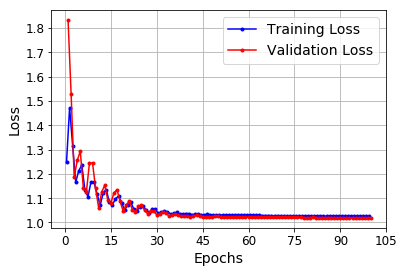

In [33]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

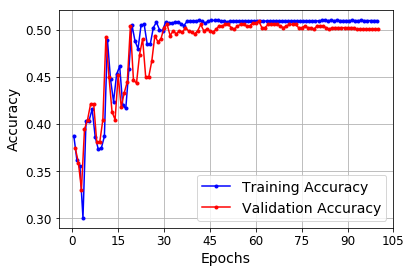

In [34]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

The accuracy seems to level out pretty quickly. To report the accuracy of the linear model, we'll average the accuracy on the validation set across the last 20 epochs of training.

In [35]:
np.mean(history.history['val_accuracy'][-20:])

0.50193924

### Deep Neural Network

The accuracy of our linear model isn't bad but it doesn't beat our benchmark. Perhaps we can do better with a more complicated model. Next, we'll create a deep neural network with keras. We'll experiment with a two layer DNN here but feel free to try a more complex model or add any other addition techinques to try an improve your performance. 

In [48]:
#TODO 1b
dnn_hidden_units = [16, 8]

model = Sequential()
for layer in dnn_hidden_units:
    model.add(Dense(units=layer,
                    activation="relu"))

model.add(Dense(units=N_LABELS,
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=50,
                    verbose=0)

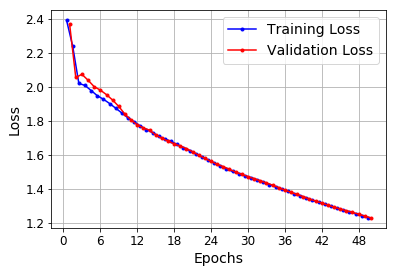

In [49]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

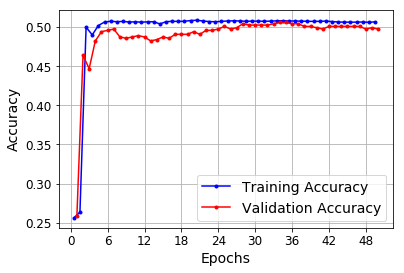

In [50]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [51]:
np.mean(history.history['val_accuracy'][-20:])

0.5013491

### Convolutional Neural Network

The DNN does slightly better. Let's see how a convolutional neural network performs. 

A 1-dimensional convolutional can be useful for extracting features from sequential data or deriving features from shorter, fixed-length segments of the data set. Check out the documentation for how to implement a [Conv1d in tensorflow.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Max pooling is a downsampling strategy commonly used in conjunction with convolutional neural networks. Next, we'll build a CNN model in keras using the `Conv1D` to create convolution layers and `MaxPool1D` to perform max pooling before passing to a fully connected dense layer. 

In [56]:
#TODO 1c
model = Sequential()

# Convolutional layer
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
model.add(Conv1D(filters=5,
                 kernel_size=5,
                 strides=2,
                 padding="valid",
                 input_shape=[None, 1]))
model.add(MaxPool1D(pool_size=2,
                    strides=None,
                    padding='valid'))


# Flatten the result and pass through DNN.
model.add(tf.keras.layers.Flatten())
model.add(Dense(units=N_TIME_STEPS//4,
                activation="relu"))

model.add(Dense(units=N_LABELS, 
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=50,
                    verbose=0)

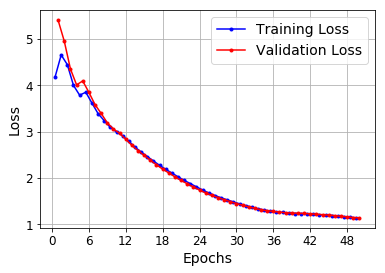

In [57]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

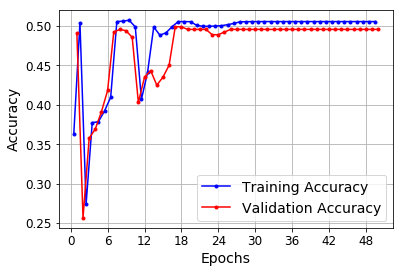

In [58]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [59]:
np.mean(history.history['val_accuracy'][-20:])

0.4957841

### Recurrent Neural Network

RNNs are particularly well-suited for learning sequential data. They retain state information from one iteration to the next by feeding the output from one cell as input for the next step. In the cell below, we'll build a RNN model in keras. The final state of the RNN is captured and then passed through a fully connected layer to produce a prediction.

In [60]:
#TODO 3a
model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
model.add(LSTM(N_TIME_STEPS//8, return_sequences=False))

model.add(Dense(units=N_LABELS,
                activation='softmax',
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

# Create the model.
model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=50,
                    verbose=0)

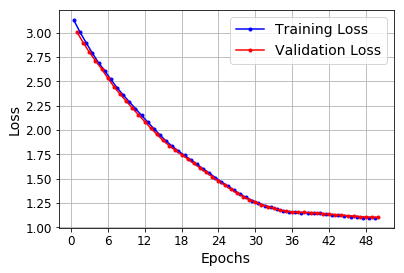

In [61]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

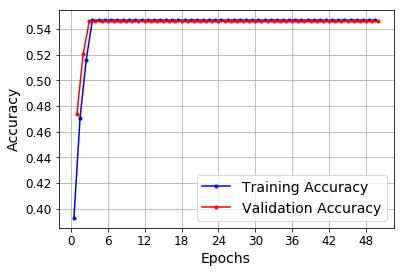

In [46]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [47]:
np.mean(history.history['val_accuracy'][-20:])

0.54597694

### Multi-layer RNN

Next, we'll build multi-layer RNN. Just as multiple layers of a deep neural network allow for more complicated features to be learned during training, additional RNN layers can potentially learn complex features in sequential data. For a multi-layer RNN the output of the first RNN layer is fed as the input into the next RNN layer.

In [53]:
#TODO 3b
rnn_hidden_units = [N_TIME_STEPS//16,
                    N_TIME_STEPS//32]

model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))

for layer in rnn_hidden_units[:-1]:
    model.add(GRU(units=layer,
                  return_sequences=True))

model.add(GRU(units=rnn_hidden_units[-1],
              return_sequences=False))
model.add(Dense(units=N_LABELS,
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=50,
                    verbose=0)

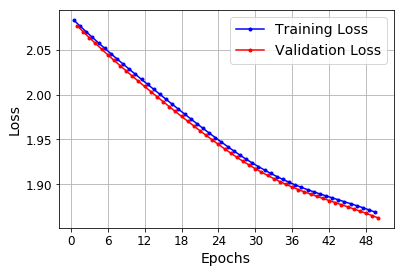

In [54]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

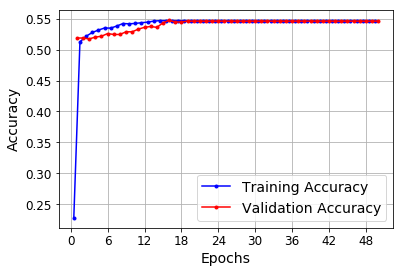

In [55]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [56]:
np.mean(history.history['val_accuracy'][-20:])

0.54597694

### Combining CNN and RNN architecture

Finally, we'll look at some model architectures which combine aspects of both convolutional and recurrant networks. For example, we can use a 1-dimensional convolution layer to process our sequences and create features which are then passed to a RNN model before prediction. 

In [16]:
#TODO 4a
model = Sequential()

# Reshape inputs for convolutional layer
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))

model.add(Conv1D(filters=20,
                 kernel_size=4,
                 strides=2,
                 padding="valid",
                 input_shape=[None, 1]))
model.add(MaxPool1D(pool_size=2,
                    strides=None,
                    padding='valid'))

model.add(LSTM(units=N_TIME_STEPS//2,
               return_sequences=False,
               kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))
model.add(Dense(units=N_LABELS, activation="softmax"))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=30,
                    verbose=0)

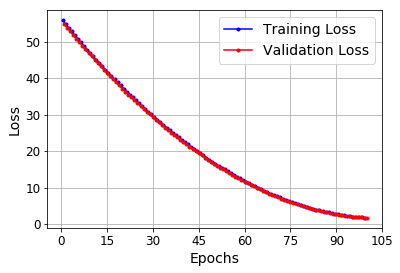

In [17]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

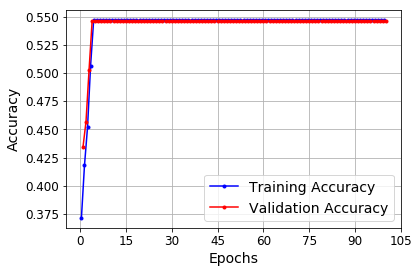

In [18]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [19]:
np.mean(history.history['val_accuracy'][-20:])

0.54597694

We can also try building a hybrid model which uses a 1-dimensional CNN to create features from the outputs of an RNN.

In [66]:
#TODO 4b
rnn_hidden_units = [N_TIME_STEPS//32,
                    N_TIME_STEPS//64]

model = Sequential()

# Reshape inputs and pass through RNN layer.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
for layer in rnn_hidden_units:
    model.add(LSTM(layer, return_sequences=True))

# Apply 1d convolution to RNN outputs.
model.add(Conv1D(filters=5,
                 kernel_size=3,
                 strides=2,
                 padding="valid"))
model.add(MaxPool1D(pool_size=4,
                    strides=None,
                    padding='valid'))

# Flatten the convolution output and pass through DNN.
model.add(tf.keras.layers.Flatten())
model.add(Dense(units=N_TIME_STEPS//32,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))
model.add(Dense(units=N_LABELS,
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=80,
                    verbose=0)

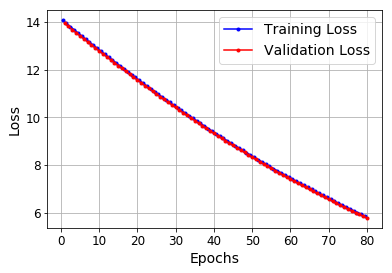

In [67]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

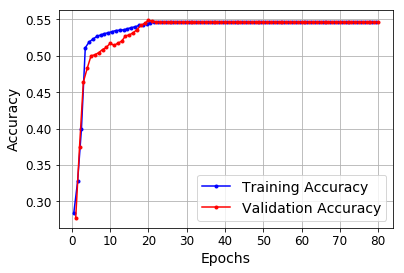

In [68]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [69]:
np.mean(history.history['val_accuracy'][-20:])

0.54597694

## Train on larger dataset using tf.data pipeline

After exploring various model architectures using a small subsample of the large dataset, we can then train a model using more of the data. To sample all of the data, we can use the code we have above setting `subsample` to be `1` when calling `create_query`. Note also, we'll rename the `.csv` files that we create. 

Note: Training on the full data set within this notebook will take substantially longer!

```pytyon
bq = bigquery.Client(project=PROJECT)

for phase in ['TRAIN', 'VALID', 'TEST']:
    # 1. Create query string
    query_string = create_query(phase, '1')
    # 2. Load results into DataFrame
    df = bq.query(query_string).to_dataframe()

    # 3. Clean, preprocess dataframe
    df = clean_data(df)
    df = create_features(df, label_name='direction_numeric')

    # 3. Write DataFrame to CSV
    if not os.path.exists('./data'):
        os.mkdir('./data')
    df.to_csv('./data/large-stock-{}.csv'.format(phase.lower()),
              index_label=False, index=False)
    print("Wrote {} lines to {}".format(
        len(df),
        './data/large-stock-{}.csv'.format(phase.lower())))
```

In [44]:
#TODO 5a
CSV_COLUMNS = COL_NAMES + [LABEL]
DEFAULTS = [[0.0]]*len(COL_NAMES) + [[0]]


def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL)

    return row_data, label  # features, label


def create_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels, num_parallel_calls=5)

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2*batch_size).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [45]:
#TODO 5b
# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in COL_NAMES
    }


def build_rnn_model():
    """Create RNN model.

    Args: None
    Returns: A tf.Keras model.
    """
    # Instatiate sequential keras model.
    model = Sequential()
    model.add(DenseFeatures(feature_columns=feature_columns.values()))

    # Reshape inputs to pass through RNN layer.
    model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
    model.add(LSTM(N_TIME_STEPS//32, return_sequences=False))

    model.add(Dense(units=N_LABELS,
                    activation='softmax',
                    kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

    # Create the model.
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

To set up our training job, let's see how many examples we have in our train, validation and test datasets.

In [34]:
!wc -l ./data/large-stock*.csv

     248431 ./data/large-stock-test.csv
    2250385 ./data/large-stock-train.csv
     264300 ./data/large-stock-valid.csv
    2763116 total


In [47]:
%%time
NUM_EPOCHS = 3
BATCH_SIZE = 500
NUM_TRAIN_EXAMPLES = 2250385

N_TIME_STEPS = 260
N_LABELS = 3

LOGDIR = './stock_trained'
shutil.rmtree(path=LOGDIR, ignore_errors=True)

get_train = create_dataset(pattern='./data/large-stock-train.csv',
                           batch_size=BATCH_SIZE,
                           mode=tf.estimator.ModeKeys.TRAIN)

get_valid = create_dataset(pattern='./data/large-stock-valid.csv',
                           batch_size=1000,
                           mode=tf.estimator.ModeKeys.EVAL).take(10)

callbacks = [
  # Save model after every epoch
  ModelCheckpoint(filepath=LOGDIR, monitor='val_accuracy', save_freq='epoch'),
  # Write TensorBoard logs output directory
  TensorBoard(log_dir=LOGDIR)
]

model = build_rnn_model()

history = model.fit(x=get_train,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=NUM_TRAIN_EXAMPLES//BATCH_SIZE,
                    validation_data=get_valid,
                    callbacks=callbacks)

Epoch 1/3
   1/4500 [..............................] - ETA: 457:37:52 - loss: 4.2433 - accuracy: 0.3320

W1103 22:16:26.848063 139737971087104 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (1.051814). Check your callbacks.


4500/4500 [==============================] - 2165s 481ms/step - loss: 3.3582 - accuracy: 0.3636 - val_loss: 3.3063 - val_accuracy: 0.0013
Epoch 2/3
4500/4500 [==============================] - 1784s 396ms/step - loss: 3.3046 - accuracy: 0.3583 - val_loss: 3.3063 - val_accuracy: 0.7694
Epoch 3/3
4500/4500 [==============================] - 1761s 391ms/step - loss: 3.3043 - accuracy: 0.3428 - val_loss: 3.3063 - val_accuracy: 0.6933
CPU times: user 3h 44min 6s, sys: 26min 54s, total: 4h 11min
Wall time: 1h 35min 17s


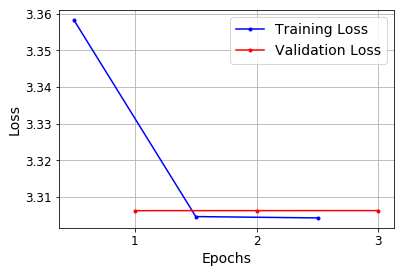

In [48]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

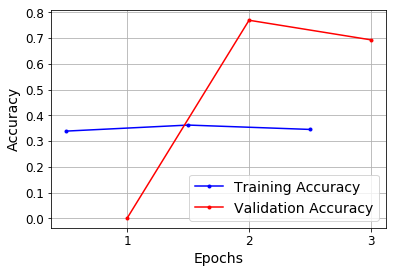

In [49]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License